<a href="https://colab.research.google.com/github/LeonardoPoliti/Brain-Tumor-Classifier/blob/main/AML_project_BrainTumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Brain Tumor Classification**
## A Comparative Analysis of Image-Based and Texture-Based Approaches

### **Leonardo Politi**
#### Master degree in Bioinformatics, University of Bologna

...............................................................................................................................

Brain tumor classification is a critical task in medical image analysis, with significant implications for diagnosis, treatment planning, and patient prognosis. Early and accurate identification of tumor type is crucial for guiding therapeutic interventions and improving patient outcomes.
Magnetic Resonance Imaging (MRI) has emerged as a valuable tool for non-invasive brain tumor assessment, providing detailed anatomical information and enabling the visualization of tumor characteristics.
In recent years, improvements in machine learning and deep learning techniques have revolutionised the field of medical image analysis, offering the potential for automated, objective and accurate tumour classification.

**AIM:** This project examines the effectiveness of texture features derived from Gray Level Co-occurrence Matrices (GLCM) in distinguishing healthy brain tissue from three distinct tumor types: Glioma, Meningioma, and Pituitary tumors. A soft-voting ensemble model, combining the predictive power of a Support Vector Classifier (SVC), a Random Forest (RF), and a Multi-Layer Perceptron (MLP), trained on extracted texture features, is evaluated against the performance of more complex Convolutional Neural Networks (CNNs),obtained through custom architecture design or transfer learning (VGG19), which directly analyze MRI images for brain tumor classification.

**DATA:** The dataset consists of approximately 7000 images obtained from magnetic resonance imaging (MRI) of healthy patients and patients with three different types of brain tumours: Glioma, Meningioma and Pituitary tumour. The data was obtained from Kaggle and was slightly modified to remove the pre-made train-test split. (https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset/data)

...................................................................................................................................

**Drive project folder:** https://drive.google.com/drive/folders/1Chuf9lPrYOU7MyEWxG14X5aPbLZa4y_c?usp=sharing

#### *N.B: Image preprocessing and features extraction (steps 1-3) are done outside the Notebook*

###  **1.  Remove duplicates:**

 The dataset appears to contain 297 duplicates, mainly in the healthy class. These duplicates, if not removed, could introduce some bias, especially if the same image is present in both the training and test sets.

 The code used to remove duplicates can be found at: https://github.com/LeonardoPoliti/Brain-Tumor-Classifier/blob/main/code/remove_duplicates.py


### **2. Rescale and crop images:**

The images in the dataset have different resolutions, and a significant portion of them also have an aspect ratio different from 1, further complicating the standardization process because rescaling these images would introduce distortions and artifacts.
To address this problem, images with aspect ratio different from 1 are cropped. Luckly, the standardized procedure for obtaining these mri images ensures that the relevant portion is always centered, allowing equal cropping from both sides of the longer dimension without risking the loss of any crucial brain structures.
Finally, all the images are rescaled to 256*256px, and since a small portion of them also have 3 channels they are converted to grayscale for consistency.
To further improve the quality of the data, the images could be cropped to retain only the portion containing the brain, effectively eliminating most of the black background.

The code used for cropping and rescaling can be found at: https://github.com/LeonardoPoliti/Brain-Tumor-Classifier/blob/main/code/rescale_images.py


### **3. GLCM features extraction:**

GLCM quantifies the spatial relationships between pairs of pixels within an image, providing a statistical representation of texture. This allows for the extraction of meaningful features like contrast, homogeneity, energy, etc., which can differentiate between different conditions of the tissue under exam.
(Kumari and Rani, 2020; https://link.springer.com/chapter/10.1007/978-3-030-46943-6_3)

The code used to generate GLCMs and extract texture features can be found at: https://github.com/LeonardoPoliti/Brain-Tumor-Classifier/blob/main/code/GLCM_features_extraction.py


### **4. Prepare environment**

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/AML_project_Leonardo_Politi

import os
from PIL import Image
import numpy as np
import pandas as pd
import random
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import make_scorer, f1_score, classification_report, confusion_matrix, roc_curve, auc

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/AML_project_Leonardo_Politi


In [2]:
# general params
# !!! do not change lists order !!!
image_size = 256      # px (assuming aspect ratio = 1)
classes = ['notumor','glioma','meningioma','pituitary']
texture_features = ['mean', 'std', 'skewness', 'kurtosis', 'entropy', 'contrast', 'energy', 'ASM', 'homogeneity', 'dissimilarity', 'correlation']
images_folder = 'brain_tumor_data'
texture_features_path = 'brain_tumor_texture.csv'
data_folder_path = 'brain_tumor_data'
n_folds = 5

In [ ]:
def convert_class_to_num(file_name):
    if'notumor' in file_name: return 0
    elif 'glioma' in file_name: return 1
    elif 'meningioma'in file_name: return 2
    elif 'pituitary'in file_name: return 3
    else: print('Error:',file_name)

#### **Load data**

In [ ]:
# Unzip data in the project folder - ignore files that are already present
%%capture
!unzip -n brain_tumor_data.zip

In [3]:
# Extract images paths and labels
image_names = []  # used to link images and texture features and split the data consistently
image_paths = []
labels = []

for class_name in os.listdir(images_folder):
    class_folder = os.path.join(images_folder, class_name)
    if os.path.isdir(class_folder):
        for filename in os.listdir(class_folder):
            image_path = os.path.join(class_folder, filename)
            image_paths.append(image_path)
            labels.append(class_name)
            image_names.append(filename)

images_df = pd.DataFrame({'path': image_paths, 'image_name': image_names, 'class': labels})
images_df

,path,image_name,class
0,brain_tumor_data/glioma/glioma_267.jpg,glioma_267.jpg,glioma
1,brain_tumor_data/glioma/glioma_1424.jpg,glioma_1424.jpg,glioma
2,brain_tumor_data/glioma/glioma_233.jpg,glioma_233.jpg,glioma
3,brain_tumor_data/glioma/glioma_1617.jpg,glioma_1617.jpg,glioma
4,brain_tumor_data/glioma/glioma_283.jpg,glioma_283.jpg,glioma
...,...,...,...
6721,brain_tumor_data/meningioma/meningioma_1605.jpg,meningioma_1605.jpg,meningioma
6722,brain_tumor_data/meningioma/meningioma_1546.jpg,meningioma_1546.jpg,meningioma
6723,brain_tumor_data/meningioma/meningioma_153.jpg,meningioma_153.jpg,meningioma
6724,brain_tumor_data/meningioma/meningioma_1582.jpg,meningioma_1582.jpg,meningioma


In [18]:
# Load texture features
texture_df = pd.read_csv(texture_features_path)

if 'Unnamed: 0' in texture_df.columns:
  texture_df = texture_df.drop(columns=['Unnamed: 0'])

texture_df

,mean,std,skewness,kurtosis,entropy,contrast,energy,ASM,homogeneity,dissimilarity,correlation,image_name,class
0,30.516235,39.544379,1.276276,1.178947,5.277698,116.698928,0.316739,0.100324,0.572910,4.618290,0.962745,glioma_001.jpg,1
1,23.515533,31.095192,1.318668,1.408460,4.876703,60.506618,0.327362,0.107166,0.616824,3.353891,0.968766,glioma_002.jpg,1
2,17.340088,25.488978,1.612426,2.970323,3.985402,34.094301,0.387729,0.150334,0.756846,1.945772,0.973816,glioma_003.jpg,1
3,31.802322,44.889325,1.498483,1.560284,5.355873,126.518689,0.292976,0.085835,0.581163,4.985907,0.968672,glioma_004.jpg,1
4,24.991058,32.658603,1.221834,0.859048,5.039060,72.498928,0.302872,0.091731,0.614904,3.478799,0.966071,glioma_005.jpg,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6721,35.990814,31.207327,0.753681,0.477615,5.982699,103.430208,0.111422,0.012415,0.437321,4.848254,0.946834,pituitary_995.jpg,3
6722,51.780975,42.879341,1.157243,2.156435,6.666787,205.611029,0.056739,0.003219,0.298748,7.311581,0.944047,pituitary_996.jpg,3
6723,56.350586,43.941834,0.544999,-0.236327,6.680429,147.914476,0.075865,0.005755,0.338946,6.447381,0.961604,pituitary_997.jpg,3
6724,51.718369,44.177880,0.738906,0.383472,6.459275,167.682675,0.103556,0.010724,0.385145,6.552926,0.956979,pituitary_998.jpg,3


### **5. Data exploration**


Text(0.5, 1.0, 'Number of images in each class')

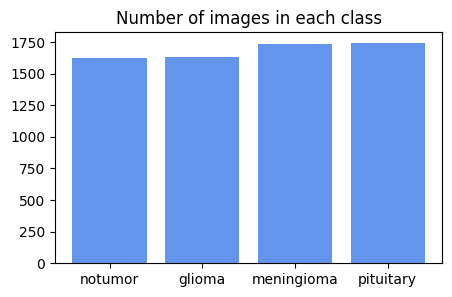

In [ ]:
# Number of images for each class
unique_labels, counts = np.unique(images_df['class'], return_counts=True)

plt.figure(figsize=(5, 3))
plt.bar(unique_labels, counts, tick_label=classes, color='#6495ED')
plt.title('Number of images in each class', fontsize=12)

The different classes have a similar number of examples, so they are not skewed and there is no need for balancing techniques or weighted loss functions during model training, for reducing the risk of overfitting to a majority class.

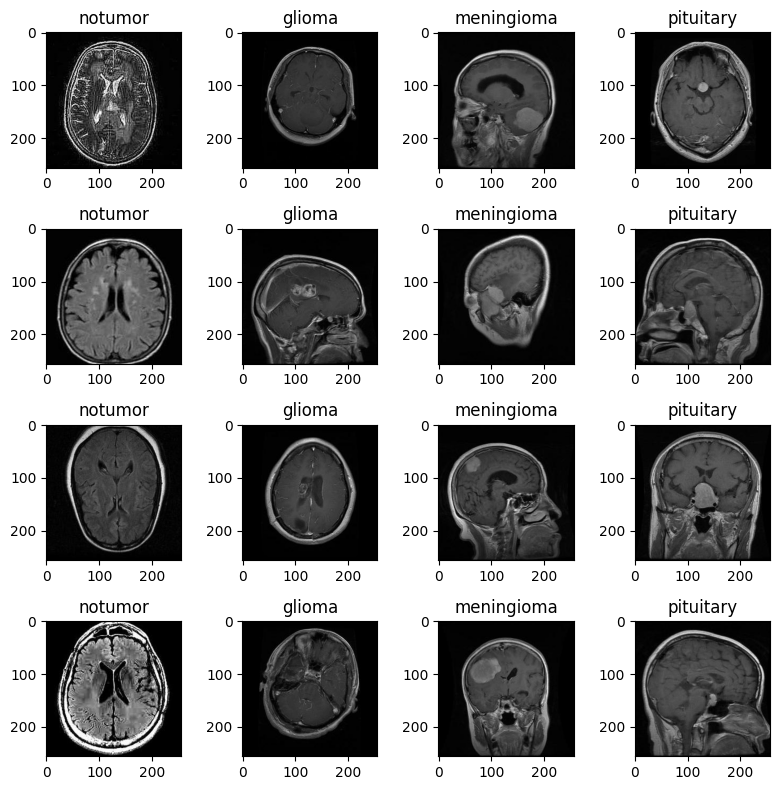

In [ ]:
# Show 4 random examples for each class
fig, axes = plt.subplots(nrows=len(classes), ncols=len(classes), figsize=(8, 8))

int_labels = images_df['class'].apply(lambda x: convert_class_to_num(x))

for i in range(len(classes)):
    class_indices = np.where(int_labels == i)[0]
    random_indices = random.sample(list(class_indices), 4)
    for j, idx in enumerate(random_indices):
        img = Image.open(images_df['path'][idx])
        axes[j, i].imshow(img,cmap='gray')
        axes[j, i].set_title(classes[i])

plt.tight_layout()

The images of the 'notumor' class, representing healthy patients, seem to be quite different from the other classes. In particular, it contains a lot of images of the dorsal view of the brain obtained by merging different datasets, while other classes seem to be more consistent and contain more examples of the lateral and back view of the brain. In addition, images in the 'notumor' class tend to be brighter, and a consistent portion of them had to be cropped to ensure an aspect ratio of 1.
This will probably result in an easier classification of this class by most algorithms, introducing a bias in the analysis. Unfortunately, I couldn't find a better dataset for this class, so I decided to use it regardless of this problem.

In [ ]:
# Check for missing data or infinite values in texture features
print('Nan :', texture_df.isnull().values.any())
print('Inf :', texture_df.isin([-np.inf,np.inf]).values.any())

Nan : False
Inf : False


In [ ]:
texture_df.drop(columns=['image_name','class']).describe()

,mean,std,skewness,kurtosis,entropy,contrast,energy,ASM,homogeneity,dissimilarity,correlation
count,6726.000000,6726.000000,6726.000000,6726.000000,6726.000000,6726.000000,6726.000000,6726.000000,6726.000000,6726.000000,6726.000000
mean,48.850079,46.875143,0.955296,0.779930,5.962169,200.967987,0.189589,0.048349,0.455808,6.105832,0.959709
std,20.037521,12.661779,0.438320,1.230133,0.772402,287.928659,0.111385,0.050224,0.133385,3.506622,0.027513
min,13.669464,20.812505,-0.642903,-1.738938,3.240880,12.442004,0.012203,0.000149,0.053937,1.486749,0.717403
25%,35.309624,38.991597,0.703853,0.002975,5.455102,98.700214,0.091914,0.008448,0.354240,4.256625,0.954167
50%,44.939964,43.666854,0.982788,0.627375,6.062512,132.867333,0.179360,0.032170,0.455244,5.444079,0.963752
75%,55.517315,50.210167,1.228756,1.442450,6.556774,180.913932,0.272574,0.074297,0.552716,6.619474,0.973646
max,145.457687,100.435614,2.898729,8.032235,7.851415,3664.765931,0.675884,0.456819,0.787305,38.817800,0.997444


**PCA analysis texture features**


Explained variance: [0.50472984 0.24339107 0.15902802 0.04853466 0.02227718 0.00931866
 0.00510585 0.00253103 0.00221165 0.00191519 0.00095684]


Text(0, 0.5, 'Cumulative Explained Variance')

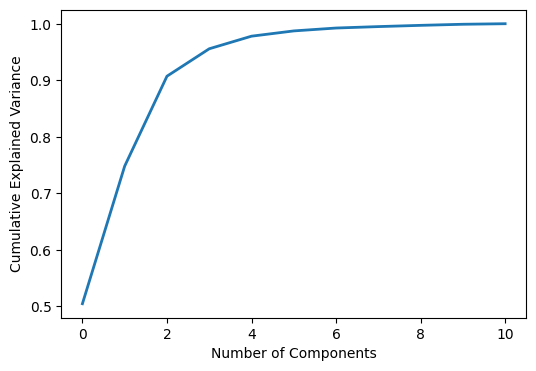

In [58]:
scaler_pca = StandardScaler()
texture_df_scaled = scaler_pca.fit_transform(texture_df.drop(columns=['image_name','class']))
pca = PCA(n_components=None)
pca.fit(texture_df_scaled)

print('Explained variance:', pca.explained_variance_ratio_)

# Plot cumulative explained variance
plt.figure(figsize=(6, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), linewidth=2)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

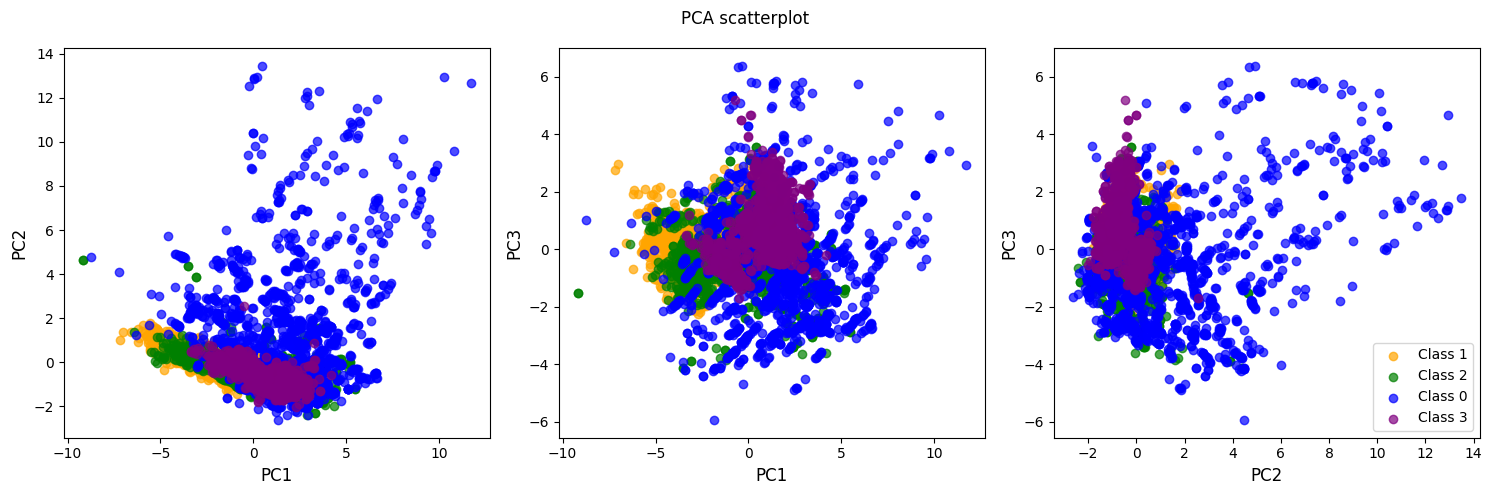

In [64]:
# Extract the 3 most important principal component
principal_components = pca.transform(texture_df_scaled)[:, :3]
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])
pca_df['class'] = texture_df['class']

# Plot 3 different views
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

color_map = {
    0: 'blue',
    1: 'orange',
    2: 'green',
    3: 'purple',
}

unique_classes = pca_df['class'].unique()

legend_elements = []
for class_label in unique_classes:
    class_data = pca_df[pca_df['class'] == class_label]
    for i, ax in enumerate(axes):
        if i == 0:
            x_col, y_col = 'PC1', 'PC2'
        elif i == 1:
            x_col, y_col = 'PC1', 'PC3'
        else:
            x_col, y_col = 'PC2', 'PC3'
        scatter = ax.scatter(class_data[x_col], class_data[y_col],
                             c=color_map[class_label], alpha=0.7, label=f'Class {class_label}')
        ax.set_xlabel(x_col, fontsize=12)
        ax.set_ylabel(y_col, fontsize=12)
        legend_elements.append(scatter)

plt.legend()
plt.suptitle('PCA scatterplot', fontsize=12)
plt.tight_layout()

The scatterplots visualize the relationships between the first three principal components (PCs) derived from texture features. Each point represents a data sample, and the colors indicate the sample's class (blue: 'notumor', yellow: 'glioma', green: 'meningioma', purple: 'pituitary).
As expected, the healthy class (blue) seems to have the greatest variability among the classes, since the images that make up this subset are retrieved by merging different sources and, as discussed earlier, they look relatively different from the rest of the dataset.
The PCA results show that the first 4-5 principal components (PCs) capture a significant portion (approximately 95-98%) of the total variance within the dataset. This suggests that these components contain the most important information for distinguishing between classes and it could be worth investigating the potential of using these PCs as input features to train the classification models, as this could lead to simplified models with reduced dimensionality while maintaining good performance (**Not done for this project!**).

### **6. Split dataset:** train (70%), validation (15%) and test (15%)

Create the same split for both images and texture features (e.g. if an image is in the train set also its texture features are in the train set)

In [ ]:
# Split images
train_images, test_images = train_test_split(images_df, test_size=0.15, random_state=5)
train_images, val_images = train_test_split(train_images, test_size=0.176, random_state=5) # 0.176 x 0.85 = 0.1496

print(f'Images split size: train = {len(train_images)}, val = {len(val_images)}, test = {len(test_images)})')

Images split size: train = 4710, val = 1007, test = 1009)


In [ ]:
# Split texture features preserving the images split
train_texture = texture_df[texture_df['image_name'].isin(train_images['image_name'])]
val_texture = texture_df[texture_df['image_name'].isin(val_images['image_name'])]
test_texture = texture_df[texture_df['image_name'].isin(test_images['image_name'])]

print(f'Texture split size: train = {len(train_texture)}, val = {len(val_texture)}, test = {len(test_texture)}')

Texture split size: train = 4710, val = 1007, test = 1009


In [ ]:
# Drop 'image_name' columns
if 'image_name' in train_texture.columns:
  train_texture = train_texture.drop(columns=['image_name'])
  val_texture = val_texture.drop(columns=['image_name'])
  test_texture = test_texture.drop(columns=['image_name'])

if 'image_name' in train_images.columns:
  train_images = train_images.drop(columns=['image_name'])
  val_images = val_images.drop(columns=['image_name'])
  test_images = test_images.drop(columns=['image_name'])

#### Check if the classes remain balanced after splitting

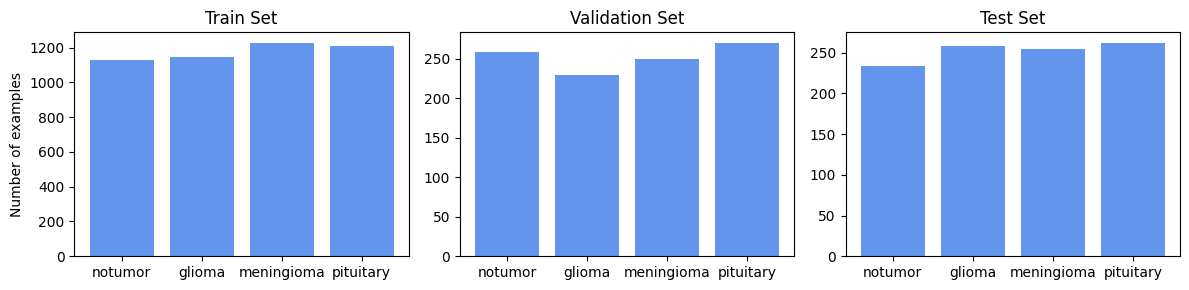

In [ ]:
unique_y_train, counts_y_train = np.unique(train_images['class'], return_counts=True)
unique_y_val, counts_y_val = np.unique(val_images['class'], return_counts=True)
unique_y_test, counts_y_test = np.unique(test_images['class'], return_counts=True)

fig, axes = plt.subplots(1, 3, figsize=(12, 3))

axes[0].bar(unique_y_train, counts_y_train, tick_label=classes, color='#6495ED')
axes[0].set_title('Train Set')
axes[0].set_ylabel('Number of examples')

axes[1].bar(unique_y_val, counts_y_val, tick_label=classes, color='#6495ED')
axes[1].set_title('Validation Set')

axes[2].bar(unique_y_test, counts_y_test, tick_label=classes, color='#6495ED')
axes[2].set_title('Test Set')

plt.tight_layout()

### **7. ImageDataGenerator and Data Scaling**

Since the dataset is relatively small, a data augmentation procedure could be applied to the training set to increase the number and variability of training examples and potentially increase the generalisation of the model.
As the classes have roughly the same number of examples, and I have limited resources to train my models, I decided not to use data augmentation for this project. This also makes it easier to maintain consistency between the images and the texture features already extracted.

In [ ]:
# ImageDataGenerators
img_gen = ImageDataGenerator(rescale=1/255)

train_generator = img_gen.flow_from_dataframe(
    dataframe=train_images,
    x_col='path',
    y_col='class',
    target_size=(image_size, image_size),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb',   # 3 channels make it easier to train vgg19
    shuffle=True
)

val_generator = img_gen.flow_from_dataframe(
    dataframe=val_images,
    x_col='path',
    y_col='class',
    target_size=(image_size, image_size),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

test_generator = img_gen.flow_from_dataframe(
    dataframe=test_images,
    x_col='path',
    y_col='class',
    target_size=(image_size, image_size),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

Found 4710 validated image filenames belonging to 4 classes.
Found 1007 validated image filenames belonging to 4 classes.
Found 1009 validated image filenames belonging to 4 classes.


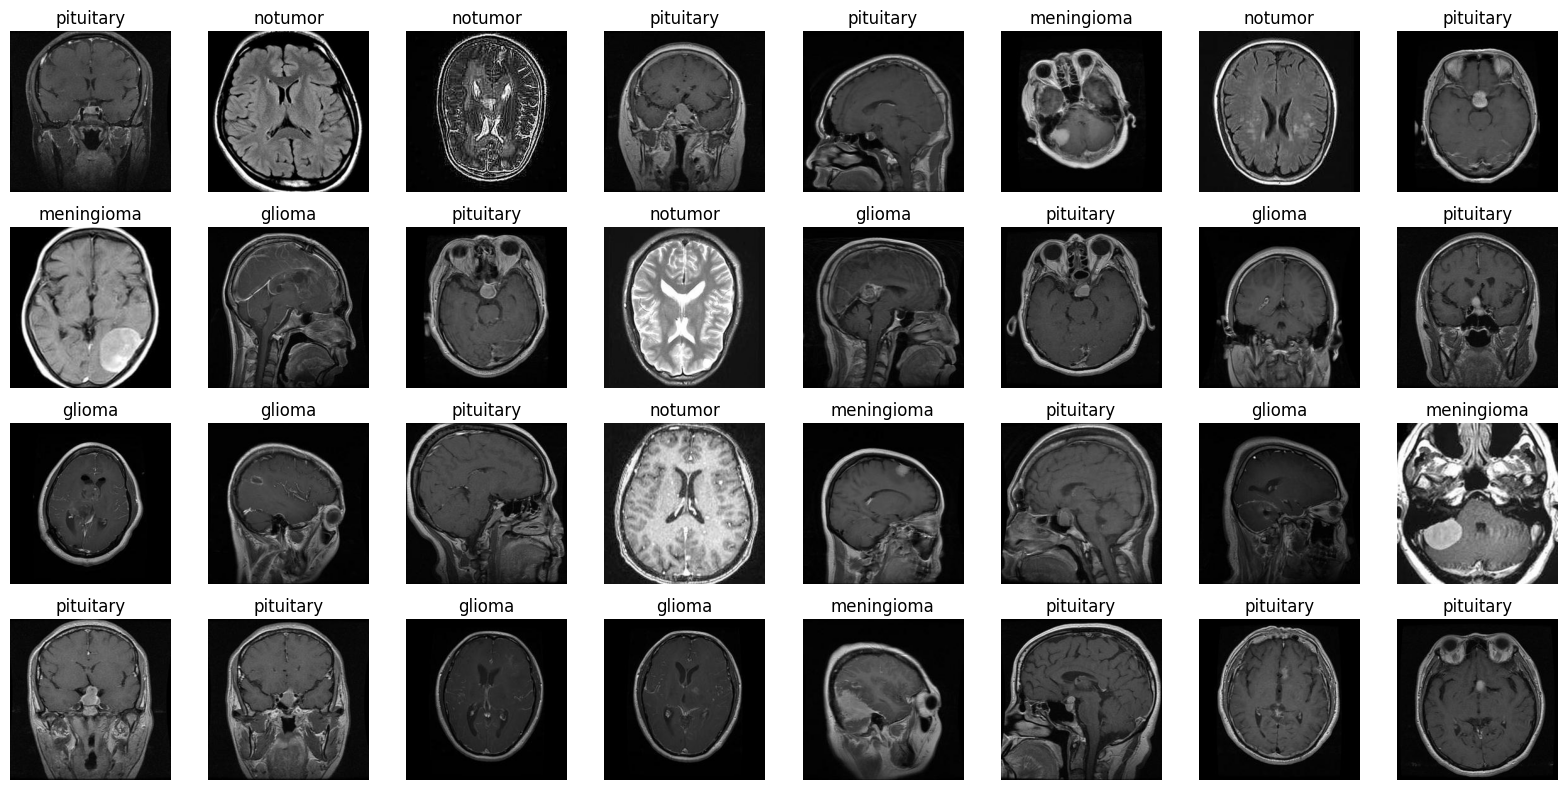

In [ ]:
# Show one batch of images
g_dict = train_generator.class_indices
classes = list(g_dict.keys())
images, labels = next(train_generator)

plt.figure(figsize= (16, 8))

for i in range(32):
    plt.subplot(4, 8, i + 1)
    img = images[i]
    plt.imshow(img,cmap='gray')
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, fontsize= 12)
    plt.axis('off')
plt.tight_layout()

In [ ]:
# Texture Features
# save labels and drop 'class' column before scaling
y_train_texture = np.array(train_texture['class'])
y_val_texture = np.array(val_texture['class'])
y_test_texture = np.array(test_texture['class'])

scaler = StandardScaler()
X_train_texture = scaler.fit_transform(train_texture.drop(columns=['class']))  # Fitting only on train set to prevent info leakage
X_val_texture = scaler.transform(val_texture.drop(columns=['class']))
X_test_texture = scaler.transform(test_texture.drop(columns=['class']))

### **8. Texture features selection**

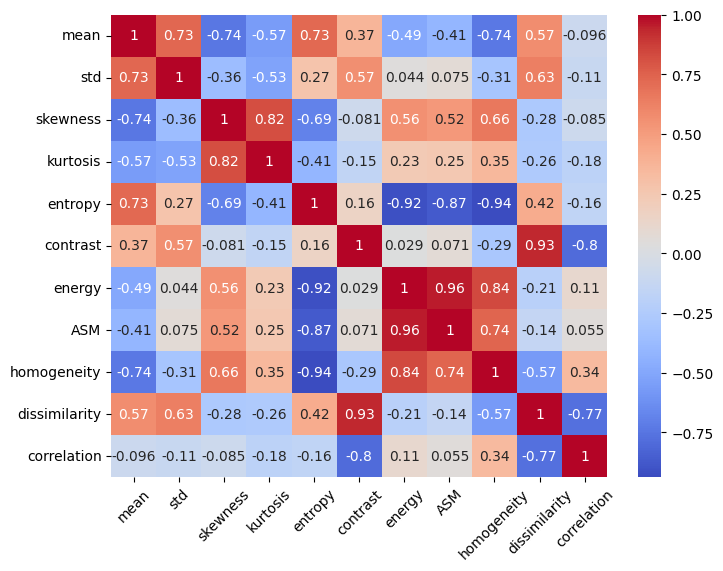

In [ ]:
# Train Set Correlation Matrix
X_train_texture_df = pd.DataFrame(X_train_texture, columns=texture_features)
corr_matrix = np.corrcoef(X_train_texture_df.T)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
ax.set_xticks(np.arange(len(texture_features)) + 0.5, labels=texture_features, rotation=45)
ax.set_yticks(np.arange(len(texture_features)) + 0.5, labels=texture_features, rotation = 0);

The correlation matrix shows that 'energy'-'ASM' pairs have almost identical correlations, suggesting they are capturing reduntant information. Keeping only one could possibly be beneficial for training the algorithms and reducing the risk of overfitting.
To confirm this hypothesis, a simple decision tree is trained and tested on the training set for 50 times, and the average importance is calculated for each feature.

In [ ]:
# Mean importance of 50 decision trees
feature_importances = pd.DataFrame(columns=texture_features)

for i in range(50):
    feature_sel_tree = DecisionTreeClassifier()
    feature_sel_tree.fit(X_train_texture, y_train_texture)

    temp_importances = pd.Series(feature_sel_tree.feature_importances_, index=texture_features)
    temp_importances= pd.DataFrame(temp_importances).T
    feature_importances = pd.concat([feature_importances, temp_importances], ignore_index=True)

feature_importances = feature_importances.mean().sort_values(ascending=False)
feature_importances

std              0.241102
dissimilarity    0.157934
skewness         0.092143
homogeneity      0.083898
mean             0.077590
kurtosis         0.073222
contrast         0.065658
ASM              0.055282
energy           0.054770
correlation      0.050495
entropy          0.047907
dtype: float64

In [ ]:
# Remove features (?)
#features_to_remove = ['energy', 'entropy'] #correlation

#print('Before remove:', X_train_texture.shape, X_val_texture.shape, X_test_texture.shape)
#X_train_texture = X_train_texture[:, ~np.isin(texture_features, features_to_remove)]
#X_val_texture = X_val_texture[:, ~np.isin(texture_features, features_to_remove)]
#X_test_texture = X_test_texture[:, ~np.isin(texture_features, features_to_remove)]
#print('After remove:', X_train_texture.shape, X_val_texture.shape, X_test_texture.shape)

Before remove: (4710, 11) (1007, 11) (1009, 11)
After remove: (4710, 9) (1007, 9) (1009, 9)


Three different types of models (SVC, Random Forest and MLP) were trained after removing different combinations of 'energy', 'entropy' and 'correlation' features to check their performance, but all trials show a slight decrease in performance after removing any feature or no change at all (**Not shown in the notebook!**). Therefore, no feature was removed for training the final models.

### **9. Train models and tune hyperparameters**
Hyperparameter tuning was conducted to explore a range of values across multiple orders of magnitude, but it could be further refined by iteratively narrowing the search space around the most promising values identified in the initial tuning phase. Moreover, various hyperparameters were not tuned at all due to the limited resources available.
The F1 score and accuracy were chosen as the primary metric for hyperparameter selection. Unlike the binary tumour-healthy classification, where a false negative (incorrectly predicting healthy when it's a tumour) carries a higher risk, the current multi-class task involves distinguishing between different tumour types, so F1 and accuracy provide a more balanced measure.
To refine this method, one could consider putting more emphasis on minimising false negatives in the healthy class, but as explained earlier in the notebook, images in the 'notumor' class seem to be slightly different from the others and are likely to be correctly classified anyway.  

#### **9.1 IMAGE ANALYSIS**

### **Convolutional Neural Network (CNN)**

In [ ]:
img_shape = (image_size, image_size, 3)

cnn = Sequential([
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(256,activation = "relu"),
    Dense(64,activation = "relu"),
    Dense(len(classes), activation = "softmax")
])

cnn.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy', Precision(), Recall()])

cnn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_49 (Conv2D)          (None, 256, 256, 64)      1792      
                                                                 
 conv2d_50 (Conv2D)          (None, 256, 256, 64)      36928     
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 128, 128, 64)      0         
 ng2D)                                                           
                                                                 
 conv2d_51 (Conv2D)          (None, 128, 128, 128)     73856     
                                                                 
 conv2d_52 (Conv2D)          (None, 128, 128, 128)     147584    
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 64, 64, 128)       0         
 ng2D)                                                

In [ ]:
checkpoint_callback = ModelCheckpoint(
    filepath='models/best_cnn.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    save_weights_only=False # Save the entire model, not just weights
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train cnn
history = cnn.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[checkpoint_callback, early_stopping_callback]
)

Epoch 1/50
148/148 [==============================] - ETA: 0s - loss: 1.1047 - accuracy: 0.5108 - precision_2: 0.7263 - recall_2: 0.3019

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


148/148 [==============================] - 53s 331ms/step - loss: 1.1047 - accuracy: 0.5108 - precision_2: 0.7263 - recall_2: 0.3019 - val_loss: 0.6364 - val_accuracy: 0.7071 - val_precision_2: 0.7358 - val_recall_2: 0.6832
Epoch 2/50
148/148 [==============================] - 52s 351ms/step - loss: 0.5935 - accuracy: 0.7546 - precision_2: 0.7835 - recall_2: 0.7085 - val_loss: 0.5414 - val_accuracy: 0.7954 - val_precision_2: 0.8160 - val_recall_2: 0.7577
Epoch 3/50
148/148 [==============================] - 48s 325ms/step - loss: 0.4679 - accuracy: 0.8079 - precision_2: 0.8253 - recall_2: 0.7851 - val_loss: 0.5208 - val_accuracy: 0.7865 - val_precision_2: 0.7945 - val_recall_2: 0.7716
Epoch 4/50
148/148 [==============================] - 53s 359ms/step - loss: 0.3872 - accuracy: 0.8418 - precision_2: 0.8539 - recall_2: 0.8316 - val_loss: 0.3826 - val_accuracy: 0.8352 - val_precision_2: 0.8536 - val_recall_2: 0.8222
Epoch 5/50
148/148 [==============================] - 53s 349ms/step - 

(0.0, 2.0)

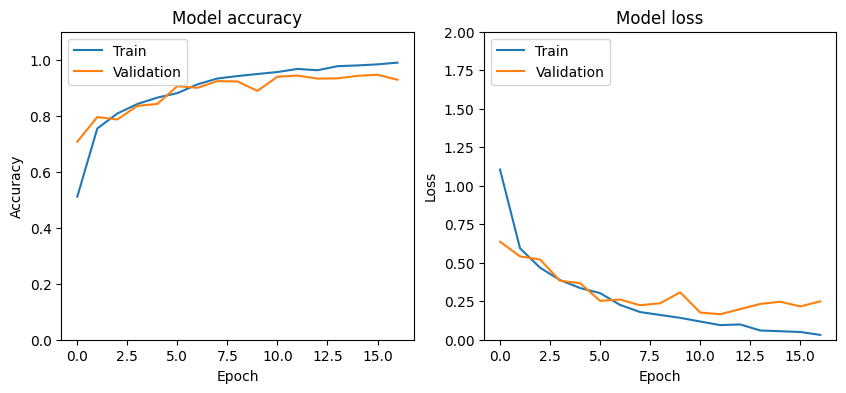

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.ylim((0,1.1))

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.ylim((0,2))

### **Transfer Learning - VGG19**

This model was built on top of a pre-trained VGG19 network and only the new layers were trained to improve the classification of brain MRI images.
The choice of VGG19 over other models was based on the results obtained by Krishnapriya and Karuna (2023, https://www.frontiersin.org/journals/human-neuroscience/articles/10.3389/fnhum.2023.1150120/full)

In [ ]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Freeze the base model's layers
for layer in base_model.layers:
    layer.trainable = False

vgg19_clf = Sequential()
vgg19_clf.add(base_model)
vgg19_clf.add(GlobalAveragePooling2D())
vgg19_clf.add(Dense(1024, activation='relu'))
vgg19_clf.add(Dropout(0.5))
vgg19_clf.add(Dense(512, activation='relu'))
vgg19_clf.add(Dropout(0.5))
vgg19_clf.add(Dense(256, activation='relu'))
vgg19_clf.add(Dropout(0.5))
vgg19_clf.add(Dense(4, activation='softmax'))

vgg19_clf.compile(optimizer=Adamax(learning_rate= 0.001), loss='categorical_crossentropy', metrics=['accuracy',Precision(), Recall()])
vgg19_clf.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_37 (Dense)            (None, 1024)              525312    
                                                                 
 dropout_12 (Dropout)        (None, 1024)              0         
                                                                 
 dense_38 (Dense)            (None, 512)               524800    
                                                                 
 dropout_13 (Dropout)        (None, 512)               0         
                                                      

In [ ]:
checkpoint_callback = ModelCheckpoint(
    filepath='models/best_vgg19.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    save_weights_only=False # Save the entire model, not just weights
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

# Train cnn
vgg19_history = vgg19_clf.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=150,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[checkpoint_callback, early_stopping_callback]
)

Epoch 1/150
148/148 [==============================] - ETA: 0s - loss: 1.2972 - accuracy: 0.3972 - precision_6: 0.5921 - recall_6: 0.1051

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


148/148 [==============================] - 31s 196ms/step - loss: 1.2972 - accuracy: 0.3972 - precision_6: 0.5921 - recall_6: 0.1051 - val_loss: 0.8785 - val_accuracy: 0.6127 - val_precision_6: 0.9144 - val_recall_6: 0.2969
Epoch 2/150
148/148 [==============================] - 28s 185ms/step - loss: 0.8570 - accuracy: 0.6261 - precision_6: 0.7530 - recall_6: 0.4168 - val_loss: 0.6518 - val_accuracy: 0.7249 - val_precision_6: 0.8264 - val_recall_6: 0.5531
Epoch 3/150
148/148 [==============================] - 28s 185ms/step - loss: 0.7171 - accuracy: 0.6894 - precision_6: 0.7571 - recall_6: 0.5624 - val_loss: 0.5637 - val_accuracy: 0.7507 - val_precision_6: 0.8173 - val_recall_6: 0.6574
Epoch 4/150
148/148 [==============================] - 28s 186ms/step - loss: 0.6397 - accuracy: 0.7282 - precision_6: 0.7807 - recall_6: 0.6418 - val_loss: 0.5196 - val_accuracy: 0.7577 - val_precision_6: 0.7809 - val_recall_6: 0.7150
Epoch 5/150
148/148 [==============================] - 27s 184ms/ste

(0.0, 2.0)

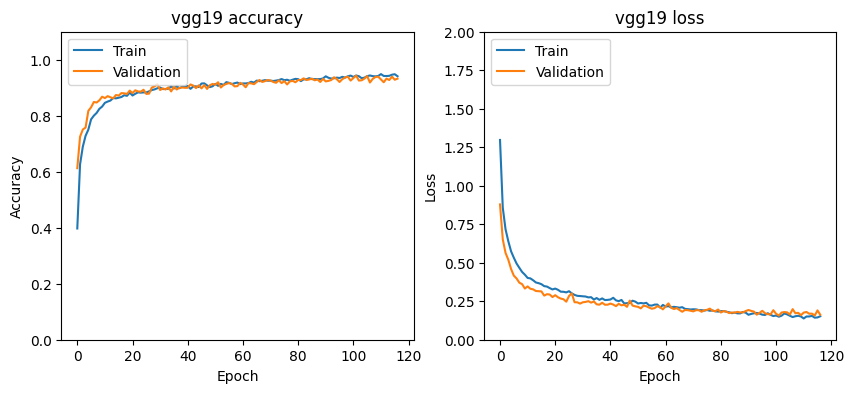

In [ ]:
# Plot training & validation accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(vgg19_history.history['accuracy'])
plt.plot(vgg19_history.history['val_accuracy'])
plt.title('vgg19 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.ylim((0,1.1))

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(vgg19_history.history['loss'])
plt.plot(vgg19_history.history['val_loss'])
plt.title('vgg19 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.ylim((0,2))

#### **9.2 TEXTURE ANALYSIS**

### **Support Vector Classifier (OvR)**

In [ ]:
# Grid search (may take some minutes)
svc = SVC(probability=True,random_state=5)

svc_hparams = {
              'C': [0.1,1,10,100,1000],
              'kernel': ['rbf'],                  # 'poly' gives problems during training
              'gamma': [0.1,1,10,100]
              }

svc_grid = GridSearchCV(estimator = svc,
                        param_grid = svc_hparams,
                        cv = n_folds,
                        scoring = ['f1_macro'],
                        refit = False,            # not automatic fit on best scoring params
                        verbose = 2)

svc_grid.fit(X_train_texture, y_train_texture)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   2.5s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   2.3s


KeyboardInterrupt: 

In [ ]:
# Grid Search results
results_df = pd.DataFrame(svc_grid.cv_results_)
columns_to_show = [f'param_{param}' for param in svc_grid.param_grid.keys()] + ['mean_test_f1_macro']
results_df = results_df[columns_to_show]
results_df.sort_values(by='mean_test_f1_macro', ascending=False).head()

,param_C,param_kernel,param_gamma,mean_test_f1_macro
13,100,rbf,1,0.879847
17,1000,rbf,1,0.878644
9,10,rbf,1,0.859036
16,1000,rbf,0.1,0.846567
12,100,rbf,0.1,0.839203


##### **best SVC evaluation with validation set**

In [ ]:
# Best SVC - manually selected based on grid search results
best_svc_params = {'C': 100, 'kernel': 'rbf', 'gamma': 1}
best_svc = SVC(**best_svc_params, probability=True, random_state=5)
best_svc.fit(X_train_texture, y_train_texture)

SVC(C=100, gamma=1, probability=True, random_state=5)

In [ ]:
y_proba_svc = best_svc.predict_proba(X_val_texture)
y_pred_svc = y_proba_svc.argmax(axis=1)

print(classification_report(y_val_texture, y_pred_svc))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       250
           1       0.92      0.79      0.85       258
           2       0.82      0.90      0.86       229
           3       0.94      0.97      0.95       270

    accuracy                           0.91      1007
   macro avg       0.91      0.91      0.91      1007
weighted avg       0.91      0.91      0.91      1007



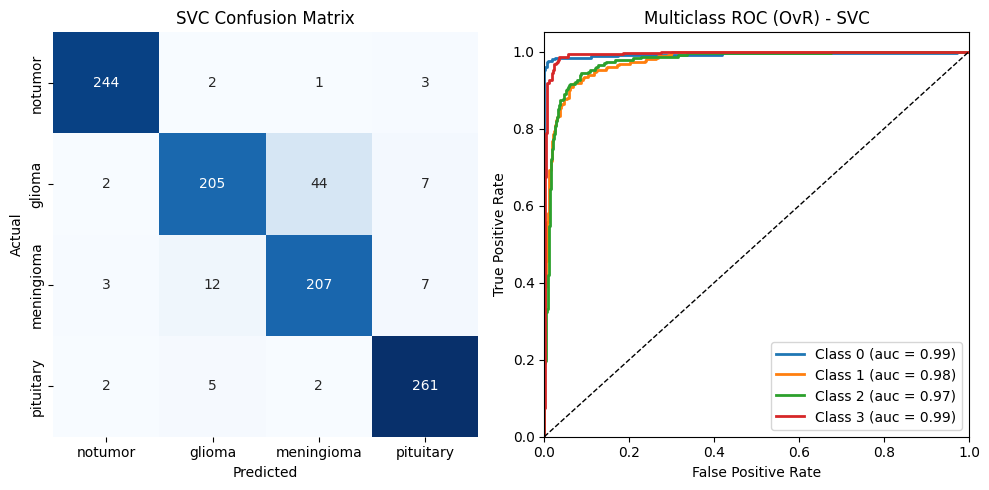

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Confusion Matrix
cm_svc = confusion_matrix(y_val_texture, y_pred_svc)
sns.heatmap(cm_svc, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes, cbar=False, ax=axes[0])
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")
axes[0].set_title("SVC Confusion Matrix")

# ROC curve and AUC
y_val_bin = label_binarize(y_val_texture, classes=best_svc.classes_)
n_classes = len(classes)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_proba_svc[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(n_classes):
    axes[1].plot(fpr[i], tpr[i], lw=2, label='Class %s (auc = %0.2f)' % (best_svc.classes_[i], roc_auc[i]))

axes[1].plot([0, 1], [0, 1], 'k--', lw=1)
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Multiclass ROC (OvR) - SVC')
axes[1].legend(loc="lower right")

plt.tight_layout()

##### **Save best SVC**

In [ ]:
with open('models/best_svc.pkl', 'wb') as f:
    pickle.dump(best_svc, f)

### **Random Forest**



In [ ]:
# Train RF (May take some minutes)
rf = RandomForestClassifier(random_state=5)

rf_hparams = {
             'criterion' :['gini', 'entropy'],
             'max_features': ['sqrt', 'log2'],
             'n_estimators': [100,200,500],
             'max_depth' : [6,7,8,9]
             }

rf_grid = GridSearchCV(estimator=rf,
                       param_grid=rf_hparams,
                       scoring=['f1_macro'],
                       cv=n_folds,
                       refit = False,
                       verbose = 2)

rf_grid.fit(X_train_texture, y_train_texture)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END criterion=gini, max_depth=6, max_features=sqrt, n_estimators=100; total time=   1.6s
[CV] END criterion=gini, max_depth=6, max_features=sqrt, n_estimators=100; total time=   1.7s
[CV] END criterion=gini, max_depth=6, max_features=sqrt, n_estimators=100; total time=   1.9s
[CV] END criterion=gini, max_depth=6, max_features=sqrt, n_estimators=100; total time=   1.7s
[CV] END criterion=gini, max_depth=6, max_features=sqrt, n_estimators=100; total time=   1.7s
[CV] END criterion=gini, max_depth=6, max_features=sqrt, n_estimators=200; total time=   3.6s
[CV] END criterion=gini, max_depth=6, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=6, max_features=sqrt, n_estimators=200; total time=   1.7s
[CV] END criterion=gini, max_depth=6, max_features=sqrt, n_estimators=200; total time=   1.6s
[CV] END criterion=gini, max_depth=6, max_features=sqrt, n_estimators=200; total time=   1.6

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=5),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [6, 7, 8, 9],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [100, 200, 500]},
             refit=False, scoring=['f1_macro'], verbose=2)

In [ ]:
# Grid Search results
results_df = pd.DataFrame(rf_grid.cv_results_)
columns_to_show = [f'param_{param}' for param in rf_grid.param_grid.keys()] + ['mean_test_f1_macro']
results_df = results_df[columns_to_show]
results_df.sort_values(by='mean_test_f1_macro', ascending=False).head()

,param_criterion,param_max_features,param_n_estimators,param_max_depth,mean_test_f1_macro
46,entropy,log2,200,9,0.818594
43,entropy,sqrt,200,9,0.818594
47,entropy,log2,500,9,0.816001
44,entropy,sqrt,500,9,0.816001
45,entropy,log2,100,9,0.813362


##### **best Random Forest evaluation with validation set**

In [ ]:
# Best Random Forest - manually selected based on grid search results
best_rf_params = {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 200, 'max_depth':9}
best_rf = RandomForestClassifier(**best_rf_params, random_state=5)
best_rf.fit(X_train_texture, y_train_texture)

RandomForestClassifier(criterion='entropy', max_depth=9, max_features='log2',
                       n_estimators=200, random_state=5)

In [ ]:
y_proba_rf = best_rf.predict_proba(X_val_texture)
y_pred_rf = y_proba_rf.argmax(axis=1)

print(classification_report(y_val_texture, y_pred_rf))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96       250
           1       0.85      0.72      0.78       258
           2       0.73      0.81      0.77       229
           3       0.86      0.91      0.89       270

    accuracy                           0.85      1007
   macro avg       0.85      0.85      0.85      1007
weighted avg       0.85      0.85      0.85      1007



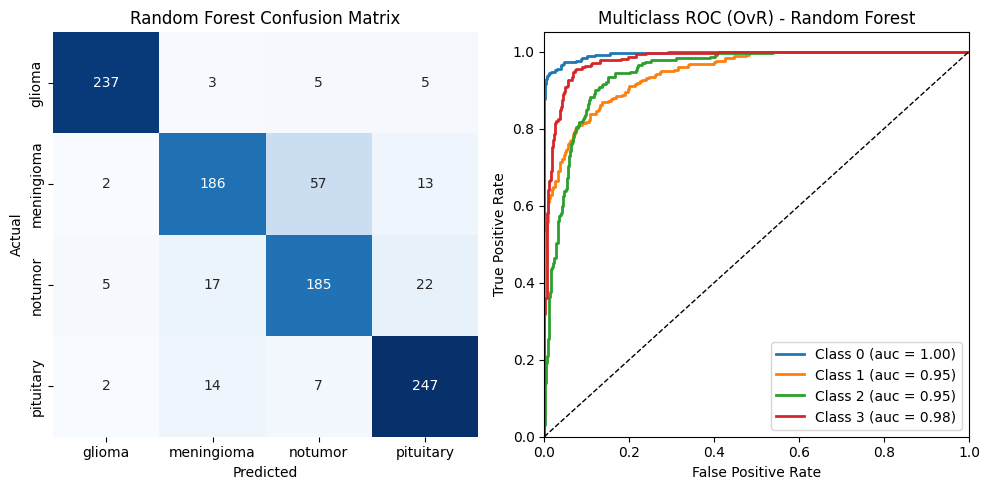

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Confusion Matrix
cm_rf = confusion_matrix(y_val_texture, y_pred_rf)
sns.heatmap(cm_rf, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes, cbar=False, ax=axes[0])
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")
axes[0].set_title("Random Forest Confusion Matrix")

# ROC curve and AUC
y_val_bin = label_binarize(y_val_texture, classes=best_rf.classes_)
n_classes = len(classes)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_proba_rf[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(n_classes):
    axes[1].plot(fpr[i], tpr[i], lw=2, label='Class %s (auc = %0.2f)' % (best_rf.classes_[i], roc_auc[i]))

axes[1].plot([0, 1], [0, 1], 'k--', lw=1)
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Multiclass ROC (OvR) - Random Forest')
axes[1].legend(loc="lower right")

plt.tight_layout()

**Save best Random Forest**

In [ ]:
with open('models/best_rf.pkl', 'wb') as f:
    pickle.dump(best_rf, f)

### **Multilayer Perceptron**

In [ ]:
# Grid search for hyperparameters selection(may take some minutes)
mlp = MLPClassifier(max_iter=500, random_state=5)

mlp_param_grid = {
    'hidden_layer_sizes': [ (128, 64, 32), (256, 128, 64), (256,128,64,32), (256,128,128,64,32)],
    'activation': ['relu','tanh'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant'],
    'batch_size':[32]
}

f1_scorer = make_scorer(f1_score, average='macro')

mlp_grid = GridSearchCV(mlp, param_grid = mlp_param_grid,
                           cv = n_folds,
                           scoring = f1_scorer,
                           verbose = 2,
                           refit = False
                           )
mlp_grid.fit(X_train_texture, y_train_texture)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(128, 64, 32), learning_rate=constant, solver=adam; total time=  29.0s
[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(128, 64, 32), learning_rate=constant, solver=adam; total time=  22.2s
[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(128, 64, 32), learning_rate=constant, solver=adam; total time=  17.8s
[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(128, 64, 32), learning_rate=constant, solver=adam; total time=  28.5s
[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(128, 64, 32), learning_rate=constant, solver=adam; total time=  15.7s
[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256, 128, 64), learning_rate=constant, solver=adam; total time=  47.0s
[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=500, random_state=5),
             param_grid={'activation': ['relu', 'tanh'],
                         'alpha': [0.0001, 0.001, 0.01], 'batch_size': [32],
                         'hidden_layer_sizes': [(128, 64, 32), (256, 128, 64),
                                                (256, 128, 64, 32),
                                                (256, 128, 128, 64, 32)],
                         'learning_rate': ['constant'], 'solver': ['adam']},
             refit=False, scoring=make_scorer(f1_score, average=macro),
             verbose=2)

In [ ]:
# Grid Search results
results_df = pd.DataFrame(mlp_grid.cv_results_)
columns_to_show = [f'param_{param}' for param in mlp_grid.param_grid.keys()] + ['mean_test_score']
results_df = results_df[columns_to_show]
results_df.sort_values(by='mean_test_score', ascending=False).head()

,param_hidden_layer_sizes,param_activation,param_solver,param_alpha,param_learning_rate,param_batch_size,mean_test_score
17,"(256, 128, 64)",tanh,adam,0.001,constant,32,0.884068
2,"(256, 128, 64, 32)",relu,adam,0.0001,constant,32,0.883581
14,"(256, 128, 64, 32)",tanh,adam,0.0001,constant,32,0.882811
13,"(256, 128, 64)",tanh,adam,0.0001,constant,32,0.880928
11,"(256, 128, 128, 64, 32)",relu,adam,0.01,constant,32,0.880715


##### **best MLP evaluation on validation set**

In [ ]:
best_mlp_params = {'activation': 'tanh', 'alpha': 0.001, 'batch_size': 32, 'hidden_layer_sizes': (256, 128, 64), 'learning_rate': 'constant', 'solver': 'adam'}
best_mlp = MLPClassifier(**best_mlp_params, max_iter=1000, random_state=5)
best_mlp.fit(X_train_texture, y_train_texture)

MLPClassifier(activation='tanh', alpha=0.001, batch_size=32,
              hidden_layer_sizes=(256, 128, 64), max_iter=1000, random_state=5)

In [ ]:
y_proba_mlp = best_mlp.predict_proba(X_val_texture)
y_pred_mlp = y_proba_mlp.argmax(axis=1)

print(classification_report(y_val_texture, y_pred_mlp))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98       250
           1       0.90      0.88      0.89       258
           2       0.86      0.89      0.87       229
           3       0.96      0.98      0.97       270

    accuracy                           0.93      1007
   macro avg       0.93      0.93      0.93      1007
weighted avg       0.93      0.93      0.93      1007



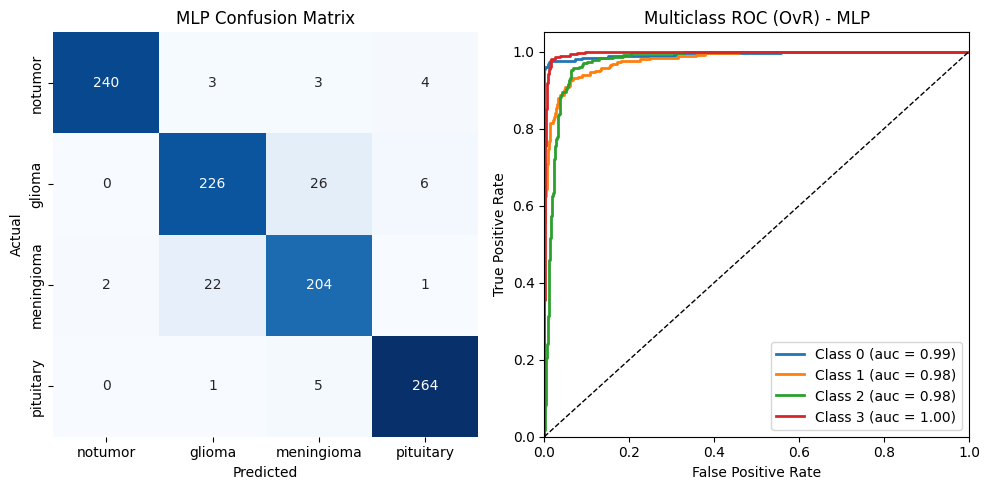

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Confusion Matrix
cm_mlp = confusion_matrix(y_val_texture, y_pred_mlp)
sns.heatmap(cm_mlp, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes, cbar=False, ax=axes[0])
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")
axes[0].set_title("MLP Confusion Matrix")

# ROC curve and AUC
y_val_bin = label_binarize(y_val_texture, classes=best_mlp.classes_)
n_classes = len(classes)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_proba_mlp[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(n_classes):
    axes[1].plot(fpr[i], tpr[i], lw=2, label='Class %s (auc = %0.2f)' % (best_mlp.classes_[i], roc_auc[i]))

axes[1].plot([0, 1], [0, 1], 'k--', lw=1)
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Multiclass ROC (OvR) - MLP')
axes[1].legend(loc="lower right")

plt.tight_layout()

##### **Save best MLP**

In [ ]:
with open('models/best_mlp.pkl', 'wb') as f:
    pickle.dump(best_mlp, f)

### **Ensemble - Soft Voting**

Given that the models trained on texture features use different logics and show comparable performance, the construction of an ensemble can potentially improve the overall classification accuracy. A soft voting ensemble, which averages the predicted probabilities of each constituent model, was trained to test this hypothesis.

In [ ]:
# Load models
# SVC
with open('models/best_svc.pkl', 'rb') as svc:
    svc_model = pickle.load(svc)
# Random Forest
with open('models/best_rf.pkl', 'rb') as rf:
    rf_model = pickle.load(rf)
# MLP
with open('models/best_mlp.pkl', 'rb') as mlp:
    mlp_model = pickle.load(mlp)

In [ ]:
voting_clf = VotingClassifier(
    estimators=[('svc', svc_model), ('rf', rf_model), ('mlp', mlp_model)],
    voting='soft',
    randon_state=5
)
voting_clf.fit(X_train_texture, y_train_texture)

VotingClassifier(estimators=[('svc', SVC(C=100, gamma=1, probability=True)),
                             ('rf',
                              RandomForestClassifier(criterion='entropy',
                                                     max_depth=9,
                                                     max_features='log2',
                                                     n_estimators=200,
                                                     random_state=5)),
                             ('mlp',
                              MLPClassifier(activation='tanh', alpha=0.001,
                                            batch_size=32,
                                            hidden_layer_sizes=(256, 128, 64),
                                            max_iter=1000, random_state=5))],
                 voting='soft')

In [ ]:
y_pred_voting_clf = voting_clf.predict(X_val_texture)
y_proba_voting_clf = voting_clf.predict_proba(X_val_texture)

print(classification_report(y_val_texture, y_pred_voting_clf))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97       250
           1       0.93      0.88      0.90       258
           2       0.87      0.92      0.89       229
           3       0.95      0.97      0.96       270

    accuracy                           0.93      1007
   macro avg       0.93      0.93      0.93      1007
weighted avg       0.93      0.93      0.93      1007



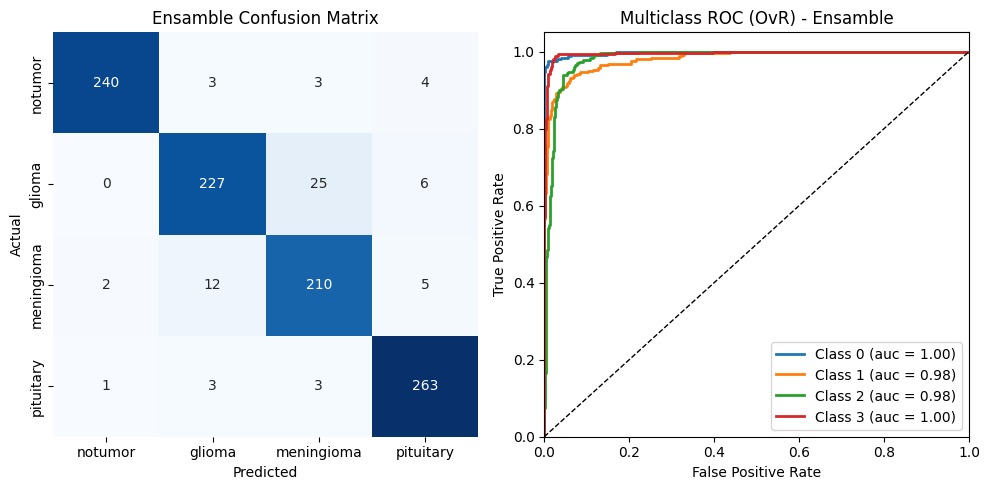

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Confusion Matrix
cm_voting_clf = confusion_matrix(y_val_texture, y_pred_voting_clf)
sns.heatmap(cm_voting_clf, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes, cbar=False, ax=axes[0])
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")
axes[0].set_title("Ensemble Confusion Matrix")

# ROC curve and AUC
y_val_bin = label_binarize(y_val_texture, classes=voting_clf.classes_)
n_classes = len(classes)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_proba_voting_clf[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(n_classes):
    axes[1].plot(fpr[i], tpr[i], lw=2, label='Class %s (auc = %0.2f)' % (voting_clf.classes_[i], roc_auc[i]))

axes[1].plot([0, 1], [0, 1], 'k--', lw=1)
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Multiclass ROC (OvR) - Ensemble')
axes[1].legend(loc="lower right")

plt.tight_layout()

The ensemble method shows slightly improved performance on the validation set compared to each individual costituent model.

**Save Ensamble**

In [ ]:
with open('models/voting_clf.pkl', 'wb') as f:
    pickle.dump(voting_clf, f)

### **10. Final models Evaluation**

In [ ]:
# Load all models

# Images
# CNN
cnn_model = tf.keras.models.load_model('models/best_cnn.h5')
# VGG19
vgg19_model = tf.keras.models.load_model('models/best_vgg19.h5')

# Texture
# SVC
with open('models/best_svc.pkl', 'rb') as svc:
    svc_model = pickle.load(svc)
# Random Forest
with open('models/best_rf.pkl', 'rb') as rf:
    rf_model = pickle.load(rf)
# MLP
with open('models/best_mlp.pkl', 'rb') as mlp:
    mlp_model = pickle.load(mlp)
# Ensemble
with open('models/voting_clf.pkl', 'rb') as voting_clf:
    voting_clf = pickle.load(voting_clf)

In [ ]:
# Images
y_pred_cnn = np.argmax(cnn_model.predict(test_generator), axis=1)
y_pred_vgg19 = np.argmax(vgg19_model.predict(test_generator), axis=1)

# Texture
y_pred_svc = svc_model.predict(X_test_texture)
y_proba_svc = svc_model.predict_proba(X_test_texture)
y_pred_rf = rf_model.predict(X_test_texture)
y_proba_rf = rf_model.predict_proba(X_test_texture)
y_pred_mlp = mlp_model.predict(X_test_texture)
y_proba_mlp = mlp_model.predict_proba(X_test_texture)
y_pred_voting_clf = voting_clf.predict(X_test_texture)
y_proba_voting_clf = voting_clf.predict_proba(X_test_texture)

32/32 [==============================] - 5s 145ms/step


**Results report**

In [ ]:
print('> CNN')
print(classification_report(test_generator.classes, y_pred_cnn))
print('> VGG19')
print(classification_report(test_generator.classes, y_pred_vgg19))
print('> SVM')
print(classification_report(y_test_texture, y_pred_svc))
print('> Random Forest')
print(classification_report(y_test_texture, y_pred_rf))
print('> MLP')
print(classification_report(y_test_texture, y_pred_mlp))
print('> Ensemble')
print(classification_report(y_test_texture, y_pred_voting_clf))

> CNN
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       234
           1       0.89      0.88      0.88       258
           2       0.99      0.96      0.97       255
           3       0.95      0.97      0.96       262

    accuracy                           0.93      1009
   macro avg       0.93      0.93      0.93      1009
weighted avg       0.93      0.93      0.93      1009

> VGG19
              precision    recall  f1-score   support

           0       0.94      0.87      0.90       234
           1       0.86      0.87      0.87       258
           2       0.97      0.98      0.97       255
           3       0.94      0.98      0.96       262

    accuracy                           0.93      1009
   macro avg       0.93      0.92      0.92      1009
weighted avg       0.93      0.93      0.93      1009

> SVM
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       255
 

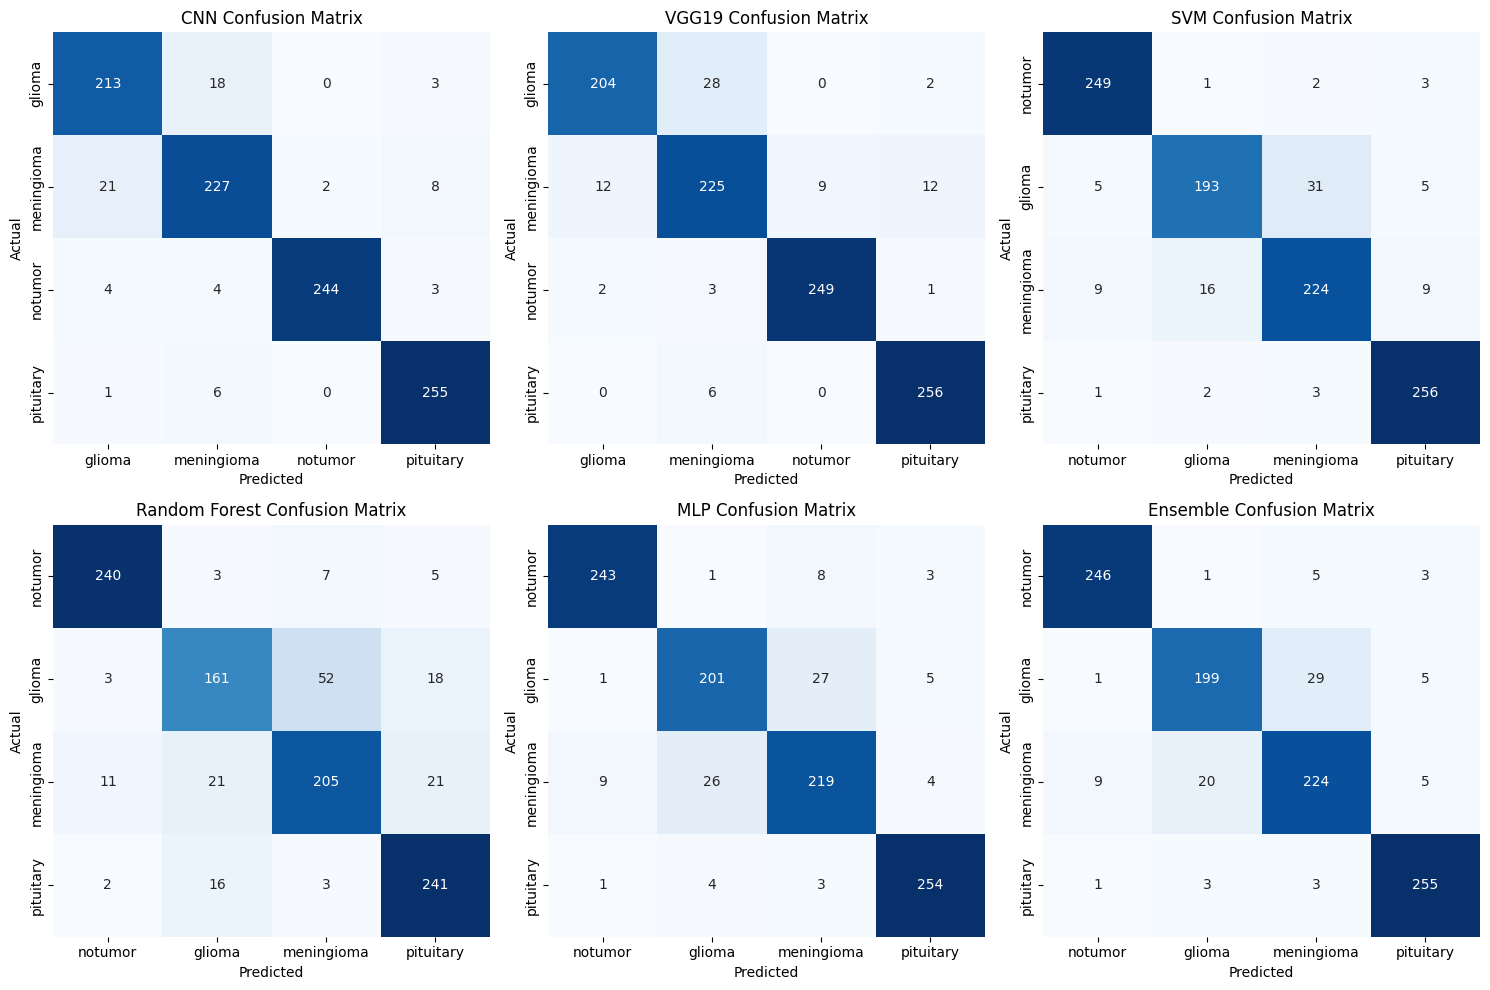

In [ ]:
# Plot confusion matrices
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# CNN
cm_cnn = confusion_matrix(test_generator.classes, y_pred_cnn)
sns.heatmap(cm_cnn, annot=True, cmap='Blues', fmt='g', xticklabels=list(test_generator.class_indices.keys()), yticklabels=list(test_generator.class_indices.keys()), cbar=False, ax=axes[0, 0])
axes[0, 0].set_xlabel("Predicted")
axes[0, 0].set_ylabel("Actual")
axes[0, 0].set_title("CNN Confusion Matrix")

# VGG19
cm_vgg19 = confusion_matrix(test_generator.classes, y_pred_vgg19)
sns.heatmap(cm_vgg19, annot=True, cmap='Blues', fmt='g', xticklabels=list(test_generator.class_indices.keys()), yticklabels=list(test_generator.class_indices.keys()), cbar=False, ax=axes[0, 1])
axes[0, 1].set_xlabel("Predicted")
axes[0, 1].set_ylabel("Actual")
axes[0, 1].set_title("VGG19 Confusion Matrix")

# SVM
cm_svc = confusion_matrix(y_test_texture, y_pred_svc)
sns.heatmap(cm_svc, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes, cbar=False, ax=axes[0, 2])
axes[0, 2].set_xlabel("Predicted")
axes[0, 2].set_ylabel("Actual")
axes[0, 2].set_title("SVM Confusion Matrix")

# Random Forest
cm_rf = confusion_matrix(y_test_texture, y_pred_rf)
sns.heatmap(cm_rf, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes, cbar=False, ax=axes[1, 0])
axes[1, 0].set_xlabel("Predicted")
axes[1, 0].set_ylabel("Actual")
axes[1, 0].set_title("Random Forest Confusion Matrix")

# MLP
cm_mlp = confusion_matrix(y_test_texture, y_pred_mlp)
sns.heatmap(cm_mlp, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes, cbar=False, ax=axes[1, 1])
axes[1, 1].set_xlabel("Predicted")
axes[1, 1].set_ylabel("Actual")
axes[1, 1].set_title("MLP Confusion Matrix")

# Ensemble
cm_voting_clf = confusion_matrix(y_test_texture, y_pred_voting_clf)
sns.heatmap(cm_voting_clf, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes, cbar=False, ax=axes[1, 2])
axes[1, 2].set_xlabel("Predicted")
axes[1, 2].set_ylabel("Actual")
axes[1, 2].set_title("Ensemble Confusion Matrix")

plt.tight_layout()

### **11. Discussion**

The results demonstrate the effectiveness of both texture-based and deep learning image processing approaches in brain tumour classification.  The custom CNN and pre-trained VGG19 model, which directly analyse the raw MRI image data, achieved the highest accuracies (93%). The texture-based ensemble model, which uses GLCM features and combines predictions from SVC, RF and MLP, showed a similar accuracy (92%) while being relatively simple and requiring less computation.
Interestingly, the Random Forest model performed significantly lower (84%) than the other classifiers. This suggests that the specific texture features extracted may be more suitable for certain algorithms and less informative for others. Notably, the ensemble approach consistently outperformed or matched the individual component classifiers.
To further refine this approach, a hybrid method could be implemented, creating a pipeline where texture features are automatically extracted from MRI images and their analysis is integrated with CNN-based predictions. This could combine the strengths of both methods and potentially further improve classification accuracy.
Finally, it is worth noting that the quality and size of the dataset used was not optimal, potentially affecting the ability of the models to generalise to unseen data. A larger and more diverse dataset would likely improve the robustness and performance of the proposed methods.